In [6]:
import pandas as pd
import numpy as np
import joblib

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score,
    recall_score, f1_score, confusion_matrix
)
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression


In [2]:
from google.colab import files

uploaded = files.upload()


Saving mitbih_train.csv.zip to mitbih_train.csv.zip
Saving mitbih_test.csv.zip to mitbih_test.csv.zip


In [3]:
!unzip -o mitbih_train.csv.zip
!unzip -o mitbih_test.csv.zip


Archive:  mitbih_train.csv.zip
  inflating: mitbih_train.csv        
Archive:  mitbih_test.csv.zip
  inflating: mitbih_test.csv         


In [4]:
TRAIN_FILE = "/content/mitbih_train.csv"
TEST_FILE  = "/content/mitbih_test.csv"

N_SPLITS = 7
RANDOM_STATE = 42
N_CLASSES = 5


In [5]:
df_train = pd.read_csv(TRAIN_FILE, header=None)
df_test  = pd.read_csv(TEST_FILE, header=None)

print("Train shape:", df_train.shape)
print("Test shape :", df_test.shape)

X_train = df_train.iloc[:, :-1]
y_train = df_train.iloc[:, -1].astype(int).values

X_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1].astype(int).values


Train shape: (87554, 188)
Test shape : (21892, 188)


In [7]:
base_models = {
    "ET": ExtraTreesClassifier(
        n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1
    ),
    "RF": RandomForestClassifier(
        n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1
    ),
    "LGB": LGBMClassifier(
        n_estimators=100, random_state=RANDOM_STATE
    ),
    "LGR": LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
}


In [8]:
skf = StratifiedKFold(
    n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE
)

meta_features = {
    name: np.zeros((len(X_train), N_CLASSES))
    for name in base_models
}
fold_scores = {name: [] for name in base_models}

for fold, (tr_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    print(f"\n Fold {fold+1}/{N_SPLITS}")

    X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train[tr_idx], y_train[val_idx]

    for name, model in base_models.items():
        model.fit(X_tr, y_tr)

        val_pred = model.predict(X_val)
        acc = accuracy_score(y_val, val_pred)
        fold_scores[name].append(acc)

        meta_features[name][val_idx, :] = model.predict_proba(X_val)

        print(f"{name} Accuracy: {acc:.4f}")



 Fold 1/7
ET Accuracy: 0.9779
RF Accuracy: 0.9760
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.205553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 47642
[LightGBM] [Info] Number of data points in the train set: 75046, number of used features: 187
[LightGBM] [Info] Start training from score -0.189065
[LightGBM] [Info] Start training from score -3.673619
[LightGBM] [Info] Start training from score -2.716494
[LightGBM] [Info] Start training from score -4.915938
[LightGBM] [Info] Start training from score -2.611174
LGB Accuracy: 0.9799
LGR Accuracy: 0.9149

 Fold 2/7
ET Accuracy: 0.9762
RF Accuracy: 0.9739
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.223705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 47631
[LightGBM] [Info] Number of data points in the train set: 75046, number of used features: 187
[Lig

In [9]:
results = pd.DataFrame(fold_scores)
results.loc["Mean"] = results.mean()
results.loc["Std"] = results.std()

print("\n Base model CV results:")
print(results.round(4))

results.to_csv("stacking_base_model_scores_ECG.csv")


 Base model CV results:
          ET      RF     LGB     LGR
0     0.9779  0.9760  0.9799  0.9149
1     0.9762  0.9739  0.9781  0.9128
2     0.9762  0.9739  0.9791  0.9141
3     0.9789  0.9779  0.9796  0.9142
4     0.9766  0.9759  0.9791  0.9145
5     0.9759  0.9743  0.9784  0.9140
6     0.9754  0.9731  0.9775  0.9114
Mean  0.9767  0.9750  0.9788  0.9137
Std   0.0011  0.0015  0.0008  0.0011


In [10]:
meta_X = np.hstack([meta_features[name] for name in base_models])
meta_y = y_train

meta_df = pd.DataFrame(meta_X)
meta_df["label"] = meta_y
meta_df.to_csv("meta_train.csv", index=False)

print("\n Saved meta_train.csv")



 Saved meta_train.csv


In [11]:
meta_model = XGBClassifier(
    n_estimators=100,
    eval_metric="mlogloss",
    random_state=RANDOM_STATE,
    num_class=N_CLASSES
)

cv_scores = cross_val_score(
    meta_model,
    meta_X,
    meta_y,
    cv=5,
    scoring="accuracy"
)

print("\n Meta-model CV:")
print(f"Mean: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

meta_model.fit(meta_X, meta_y)
joblib.dump(meta_model, "stacking_meta_model.pkl")
print("Saved stacking_meta_model.pkl")



 Meta-model CV:
Mean: 0.9832 ± 0.0009
Saved stacking_meta_model.pkl


In [13]:
final_base_models = {}

for name, base_model in base_models.items():
    model = clone(base_model)
    model.fit(X_train, y_train)
    final_base_models[name] = model

meta_test = np.hstack([
    model.predict_proba(X_test)
    for model in final_base_models.values()
])

meta_pred_test = meta_model.predict(meta_test)
joblib.dump(final_base_models, "stacking_base_models.pkl")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.132475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 47681
[LightGBM] [Info] Number of data points in the train set: 87554, number of used features: 187
[LightGBM] [Info] Start training from score -0.189069
[LightGBM] [Info] Start training from score -3.673398
[LightGBM] [Info] Start training from score -2.716469
[LightGBM] [Info] Start training from score -4.916982
[LightGBM] [Info] Start training from score -2.611126


['stacking_base_models.pkl']

In [14]:
accuracy = accuracy_score(y_test, meta_pred_test)
precision = precision_score(y_test, meta_pred_test, average="macro")
recall = recall_score(y_test, meta_pred_test, average="macro")
f1 = f1_score(y_test, meta_pred_test, average="macro")

cm = confusion_matrix(y_test, meta_pred_test)

print("\nTEST PERFORMANCE:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")
print("\nConfusion Matrix:\n", cm)



TEST PERFORMANCE:
Accuracy : 0.9833
Precision: 0.9403
Recall   : 0.8915
F1-score : 0.9145

Confusion Matrix:
 [[18042    45    17     5     9]
 [  125   427     2     1     1]
 [   64     5  1359    15     5]
 [   22     0    14   126     0]
 [   31     1     4     0  1572]]


<function matplotlib.pyplot.show(close=None, block=None)>

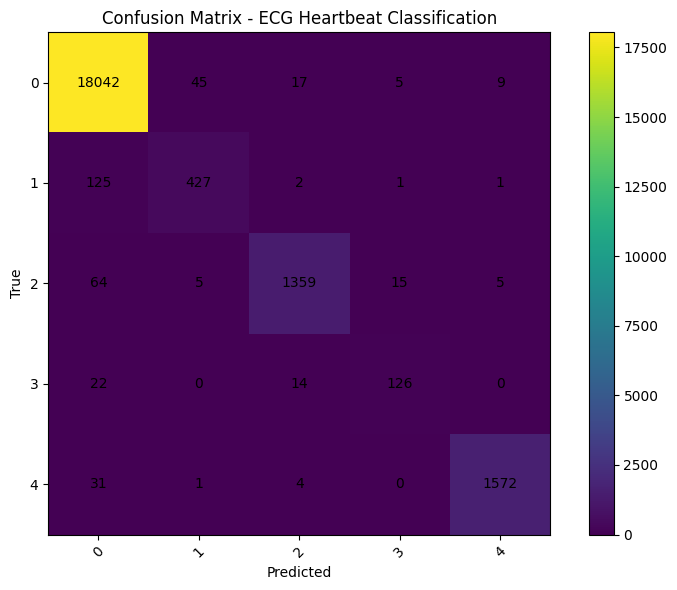

In [15]:
import matplotlib.pyplot as plt
class_names = [
    "0",
    "1",
    "2",
    "3",
    "4"
]

plt.figure(figsize=(8, 6))
plt.imshow(cm)
plt.title("Confusion Matrix - ECG Heartbeat Classification")
plt.colorbar()

plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
plt.yticks(np.arange(len(class_names)), class_names)


for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j, i, cm[i, j],
            ha="center", va="center"
        )

plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()

plt.show

In [16]:
from sklearn.metrics import classification_report
import pandas as pd

class_names = [
    "0",
    "1",
    "2",
    "3",
    "4"
]

overall_accuracy = accuracy_score(y_test, meta_pred_test)

report_dict = classification_report(
    y_test,
    meta_pred_test,
    target_names=class_names,
    output_dict=True
)

df_report = pd.DataFrame(report_dict).transpose()

rows = (
    class_names +
    ["macro avg", "weighted avg"]
)

df_report = df_report.loc[rows]

df_report = df_report.rename(columns={
    "precision": "precision",
    "recall": "recall",
    "f1-score": "f1_score",
    "support": "support"
})

accuracy_row = pd.DataFrame(
    {
        "precision": [overall_accuracy],
        "recall": [overall_accuracy],
        "f1_score": [overall_accuracy],
        "support": [df_report.loc[class_names, "support"].sum()]
    },
    index=["overall_accuracy"]
)

df_report = pd.concat([df_report, accuracy_row])

df_report_display = df_report.round(4)

out_file = "full_classification_metrics.csv"
df_report_display.to_csv(out_file)

print(f" Saved full metrics to {out_file}")
display(df_report_display)



 Saved full metrics to full_classification_metrics.csv


,precision,recall,f1_score,support
0,0.9868,0.9958,0.9913,18118.0
1,0.8933,0.7680,0.8259,556.0
2,0.9735,0.9385,0.9557,1448.0
3,0.8571,0.7778,0.8155,162.0
4,0.9905,0.9776,0.9840,1608.0
macro avg,0.9403,0.8915,0.9145,21892.0
weighted avg,0.9828,0.9833,0.9829,21892.0
overall_accuracy,0.9833,0.9833,0.9833,21892.0
